# BGE Adam Optimizer Implementation

## Overview
This notebook implements the Binary Gradient Estimation (BGE) variant of the Adam optimizer

## Table of Contents
1. [Import Libraries and Dependencies](#import-libraries-and-dependencies)
2. [Helper Functions for Plotting and Test Functions](#helper-functions-for-plotting-and-test-functions)
    - Test Function Definitions
    - Plotting Test Functions
    - Helper Plotting Function
3. [BGE Adam Optimizer Class Implementation](#bge-adam-optimizer-class-implementation)
4. [Example Use of BGE Adam Optimizer](#example-use-of-bge-adam-optimizer)
    - Helper Functions for Testing
    - Example: Using the BGE Adam Optimizer
5. [Testing and Validation](#testing-and-validation)
    - Optimizer Parameter Preparation
    - Quadratic Function (Well-Conditioned)
    - Quadratic Function (Poorly-Conditioned)
    - Non-Convex Gaussian Kernel
    - Rosenbrock Function
    - Ackley Function (Local Minima)

---

## Import Libraries and Dependencies

In [1]:
#Importation of modules that were going to use
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
import torch
import torch.optim as optim
from typing import Optional, List, Callable, Tuple, Iterator
from collections import defaultdict
from itertools import product
from typing import Any, Dict, List, Tuple, Callable, Literal, Optional, Union

## Helper functions for Plotting and Test Functions

### Test Functions

In [29]:
def quad(epsilon, ndim=2):
    def f(x):
        scaled_x = x * epsilon**torch.arange(ndim, dtype=torch.float32)
        return 1/ndim * scaled_x.pow(2).sum()

    def f_prime(x):
        scaling = epsilon**torch.arange(ndim, dtype=torch.float32)
        return 2/ndim * scaling * x * scaling

    return f, f_prime

def gaussian(x):
    return torch.exp(-torch.sum(x**2))

def gaussian_prime(x):
    return -2 * x * torch.exp(-torch.sum(x**2))

def gauss(epsilon, ndim=2):
    def f(x):
        y = x * 0.5 * torch.pow(epsilon, torch.arange(ndim, dtype=torch.float32))
        return 1 - gaussian(y)

    def f_prime(x):
        scaling = 0.5 * torch.pow(epsilon, torch.arange(ndim, dtype=torch.float32))
        y = x * scaling
        return -scaling * gaussian_prime(y)

    return f, f_prime

def rosenbrock(x):
    r = torch.sum(100.0 * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)
    return r

def rosenbrock_grad(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = torch.zeros_like(x)
    der[1:-1] = (200 * (xm - xm_m1**2) - 400 * (xm_p1 - xm**2) * xm - 2 * (1 - xm))
    der[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    der[-1] = 200 * (x[-1] - x[-2]**2)
    return der

def ackley(x, a=20, b=0.2, c=2*math.pi):
    d = len(x)
    sum1 = torch.sum(x**2)
    sum2 = torch.sum(torch.cos(c*x))
    term1 = -a * torch.exp(-b*torch.sqrt(sum1/d))
    term2 = -torch.exp(sum2/d)
    y = term1 + term2 + a + torch.exp(torch.tensor(1.0))
    return y

def ackley_grad(x: torch.Tensor, a=20, b=0.2, c=2*math.pi):
    d = len(x)
    sum1 = torch.sum(x**2)
    sum2 = torch.sum(torch.cos(c*x))
    exp_term1 = torch.exp(-b*torch.sqrt(sum1/d))
    exp_term2 = torch.exp(sum2/d)
    factor1 = 2*a*b / d * (x / torch.sqrt(d*sum1)) * exp_term1
    factor2 = -c * torch.sin(c*x) * exp_term2 / d
    gradient = factor1 + factor2
    return gradient


### Plotting of the test functions

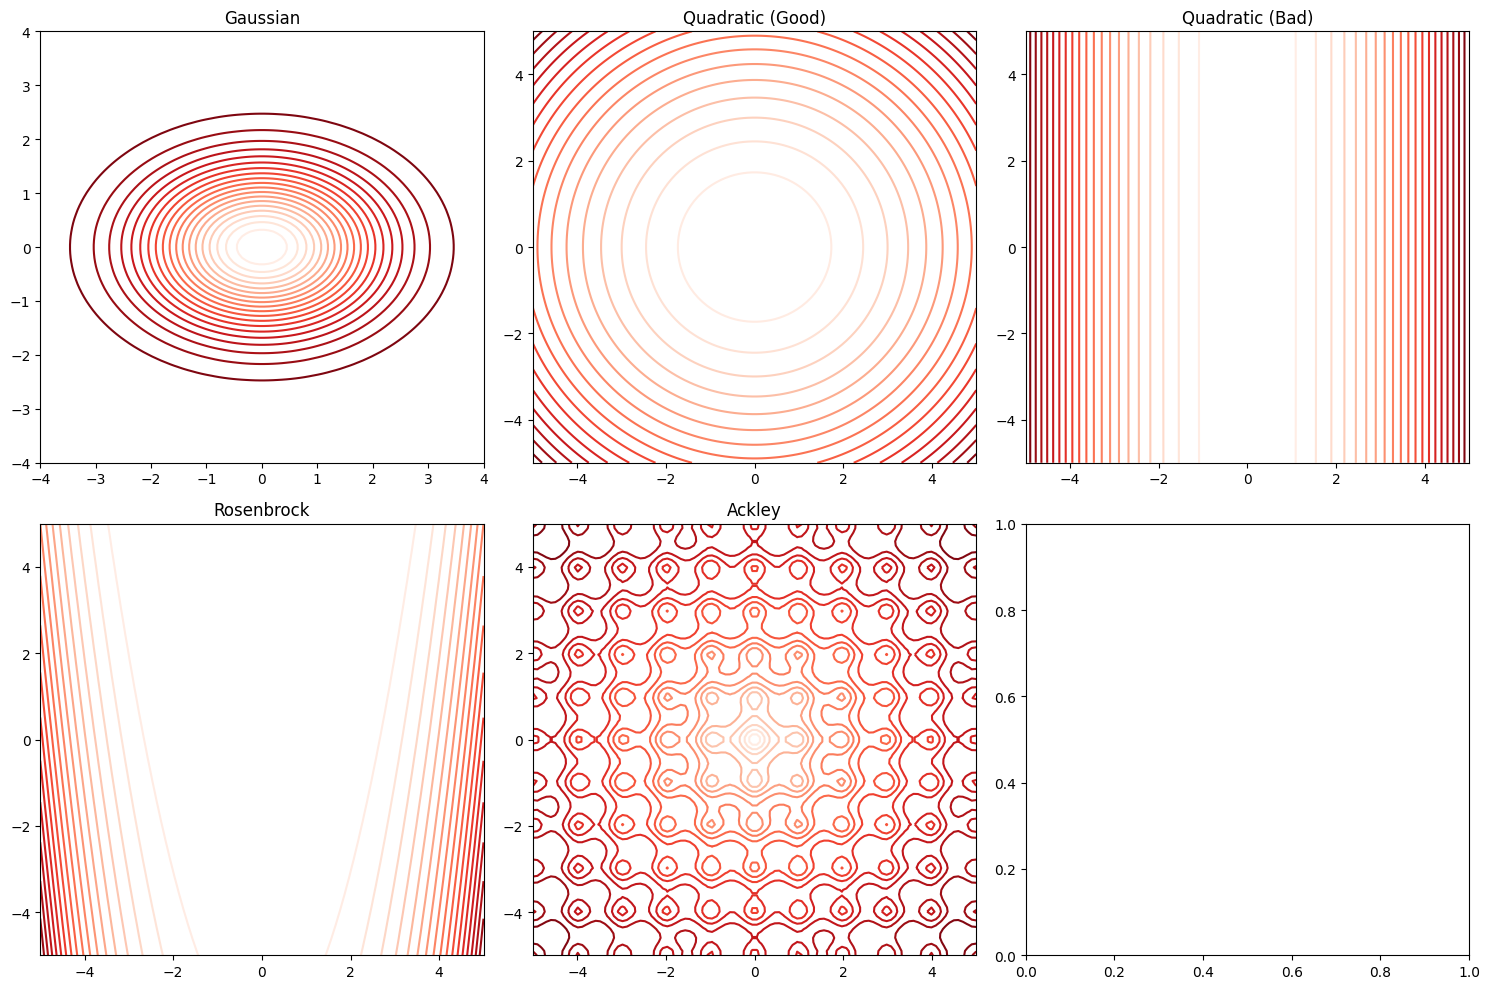

In [30]:
# Test Functions
quadratic_good, quadratic_good_grad = quad(1)
quadratic_bad, quadratic_bad_grad = quad(0.02)
gauss, gauss_grad = gauss(1.4)

gauss_range = 4
x_gauss = torch.linspace(-gauss_range, gauss_range, 100)
y_gauss = torch.linspace(-gauss_range, gauss_range, 100)
X_gauss, Y_gauss = torch.meshgrid(x_gauss, y_gauss)

functions = [gauss, quadratic_good, quadratic_bad, rosenbrock, ackley]
function_names = ['Gaussian', 'Quadratic (Good)', 'Quadratic (Bad)', 'Rosenbrock', 'Ackley']

# Create a custom colormap with shades of red
red_cmap = plt.cm.Reds

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for ax, function, name in zip(axes.flatten(), functions, function_names):
    if function == gauss:
        X, Y = X_gauss, Y_gauss
    else:
        x = torch.linspace(-5, 5, 100)
        y = torch.linspace(-5, 5, 100)
        X, Y = torch.meshgrid(x, y)

    Z = torch.zeros_like(X)
    for i, j in product(range(X.shape[0]), range(X.shape[1])):
        point = torch.tensor([X[i, j].item(), Y[i, j].item()])
        Z[i, j] = function(point)

    X = X.detach().numpy()
    Y = Y.detach().numpy()
    Z = Z.detach().numpy()

    # Use the red colormap for contours
    contour = ax.contour(X, Y, Z, levels=20, cmap=red_cmap)
    ax.set_title(name)

plt.tight_layout()
plt.show()

### Plotting Helper functions

In [31]:
def plot_convergence_path(solutions, loss_fn, x_star, box_scale=1.5):
    # Convert solutions to torch tensors
    solutions = [torch.tensor(sol, dtype=torch.float32) for sol in solutions]

    # Evaluate loss for each solution
    losses = [loss_fn(sol) for sol in solutions]

    # Convert solutions and losses to numpy arrays for plotting
    solutions_np = np.array([sol.numpy() for sol in solutions])
    losses_np = np.array(losses)

    # Calculate box boundaries
    x_min, y_min = solutions_np.min(axis=0) - box_scale
    x_max, y_max = solutions_np.max(axis=0) + box_scale

    # Plot contour levels within the box
    x_range = np.linspace(x_min, x_max, 100)
    y_range = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = loss_fn(torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32))

    plt.contour(X, Y, Z, levels=20, cmap='viridis')

    # Plot convergence path
    plt.scatter(solutions_np[:, 0], solutions_np[:, 1], c=losses_np, cmap='Reds', marker='x')
    plt.plot(solutions_np[:, 0], solutions_np[:, 1], linestyle='-', color='blue', linewidth=2)

    # Highlight the final solution
    plt.scatter(x_star[0], x_star[1], c='green', marker='o', label='Target Solution')

    # Set plot labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Convergence Path')

    plt.legend()
    plt.show()

def plot_multiple_convergence_paths(solutions, loss_fn, x_star, box_scale=1.5, title=""):
    # ========= Graph 1
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=14)
    # Plotting || x - x_star ||
    plt.subplot(1, 2, 1)
    for optim_name, path in solutions.items():
        if "local" in optim_name.lower():
            continue
        x_diff = np.linalg.norm(np.array(path) - np.array(x_star), axis=1)

        # Remove outliers based on z-scores
        plt.plot(np.arange(1, len(x_diff) + 1), x_diff, label=f"{optim_name}")

    plt.xlabel('Number of Iterations')
    plt.ylabel('$\log || x - x* ||$')
    plt.yscale('log')  # Use log scale for better visualization
    plt.legend()
    plt.title('Convergence Path for x')

    # ======== Graph 2
    # Convert solutions to torch tensors
    solutions_tensor = {
        alg: [torch.tensor(sol, dtype=torch.float32) for sol in paths]
        for alg, paths in solutions.items()
    }

    # Calculate box boundaries centered around x_star
    all_solutions_np = np.concatenate(
        [np.array(paths) for paths in solutions_tensor.values()]
    )
    x_center, y_center = x_star.numpy()
    x_min, x_max = x_center - box_scale, x_center + box_scale
    y_min, y_max = y_center - box_scale, y_center + box_scale

    # Plot contour levels within the box
    x_range = np.linspace(x_min, x_max, 100)
    y_range = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = loss_fn(
                torch.tensor([X[i, j], Y[i, j]], dtype=torch.float32)
            )

    plt.subplot(1, 2, 2)
    plt.contour(X, Y, Z, levels=20, cmap='cividis')

    # Plot convergence paths for each algorithm
    for alg, paths in solutions_tensor.items():
        paths_np = np.array([sol.numpy() for sol in paths])
        plt.plot(paths_np[:, 0], paths_np[:, 1], label=alg)

    # Highlight the final solution
    plt.scatter(x_star[0], x_star[1], c='red', marker='x', label='Target Solution')

    # Set plot labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Convergence Paths')

    plt.legend()
    plt.show()

## BGE Adam Optimizer Class Implementation from scratch

In [28]:
import torch
import math
from collections import defaultdict

class GradientPredictionModel:
    def __init__(self, alpha):
        self.alpha = alpha
        self.prev_grad = None

    def predict(self, grad):
        if self.prev_grad is None or self.prev_grad.size() != grad.size():
            self.prev_grad = torch.zeros_like(grad)
        predicted_grad = self.alpha * self.prev_grad + (1 - self.alpha) * grad
        self.prev_grad = predicted_grad.detach()
        return predicted_grad

def compute_gradient_change_rate(grad, prev_grad):
    if prev_grad is None or prev_grad.size() != grad.size():
        return 0
    change_rate = torch.norm(grad - prev_grad) / (torch.norm(prev_grad) + 1e-8)
    return change_rate.item()

def compute_dynamic_beta(change_rate, min_val, max_val):
    beta = min_val + (max_val - min_val) * (1 - change_rate)
    return min(max(beta, min_val), max_val)

class BGE_Adam():
    def __init__(self, params, lr=0.001, alpha=0.5, betas=(0.9, 0.999), eps=1e-8, weight_decay=0,
                 entropy_weight=0.01, amsgrad=False, beta1_max=0.9, beta1_min=0.5, beta2_max=0.999,
                 beta2_min=0.9):
        self.defaults = dict(lr=lr, alpha=alpha, betas=betas, eps=eps, weight_decay=weight_decay,
                        entropy_weight=entropy_weight, amsgrad=amsgrad,
                        beta1_max=beta1_max, beta1_min=beta1_min,
                        beta2_max=beta2_max, beta2_min=beta2_min)
        self.gradient_prediction_model = {}
        self.state = defaultdict(dict)
        self.param_groups = []

        param_groups = list(params)
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]
        for param_group in param_groups:
            param_group['params'] = list(param_group['params'])
            for name, default in self.defaults.items():
                param_group.setdefault(name, default)
            self.param_groups.append(param_group)

    def zero_grad(self, set_to_none: bool = False):
            for group in self.param_groups:
                for p in group['params']:
                    if p.grad is not None:
                        if set_to_none:
                            p.grad = None
                        else:
                            if p.grad.grad_fn is not None:
                                p.grad.detach_()
                            else:
                                p.grad.requires_grad_(False)
                            p.grad.zero_()

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                amsgrad = group['amsgrad']
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad.add_(p.data, alpha=group['weight_decay'])

                # Compute beta1 and beta2 values dynamically based on gradient change rate
                prev_grad = state['exp_avg'] if 'exp_avg' in state else None
                gradient_change_rate = compute_gradient_change_rate(grad, prev_grad)
                beta1 = compute_dynamic_beta(gradient_change_rate, group['beta1_min'], group['beta1_max'])
                beta2 = compute_dynamic_beta(gradient_change_rate, group['beta2_min'], group['beta2_max'])

                # Update the moving averages of gradient and its square
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                if amsgrad:
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Prediction of next gradient (gradient_prediction_model)
                if p in self.gradient_prediction_model:
                    predicted_grad = self.gradient_prediction_model[p].predict(grad)
                else:
                    self.gradient_prediction_model[p] = GradientPredictionModel(group['alpha'])
                    predicted_grad = self.gradient_prediction_model[p].predict(grad)

                # Final parameter update with entropy adjustment
                entropy_adjustment = 1 + group['entropy_weight'] * torch.randn_like(p.data).mean()
                p.data.addcdiv_(predicted_grad, denom, value=-step_size * entropy_adjustment)

        return loss

from typing import Optional, List, Callable, Tuple

class AdamOptimizer():
    def __init__(self,
        lr: float=0.001,
        beta1: float=0.9,
        beta2: float=0.999,
        epsilon: float=1e-8,
        use_ema: bool=False,
        tol_grad: float=1e-6
    ) -> None:
        self.learning_rate = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.use_ema = use_ema
        self.tol_grad = tol_grad
        self.momentums: Optional[torch.Tensor] = None
        self.velocities: Optional[torch.Tensor] = None
        self.all_x_k: Optional[List[torch.Tensor]] = None
        self.all_f_k: Optional[List[float]] = None
        self.iter: torch.IntTensor = torch.tensor(0)
        self.initial_guess: Optional[torch.Tensor] = None

    def initialize(self, var: torch.Tensor) -> None:
        self.momentums = torch.zeros_like(var)
        self.velocities = torch.zeros_like(var)
        self.all_x_k = []
        self.all_f_k = []
        self.iter = torch.tensor([0])
        self.initial_guess = var

    def update_step(
            self,
            theta: torch.Tensor,
            f: Callable,
            f_grad: Callable,
            f_grad_args: Tuple = ()
    ) -> Tuple[torch.Tensor, float, torch.Tensor]:
        theta_old = torch.tensor(theta) if not torch.is_tensor(theta) else theta.clone()
        self.iter += 1
        beta1_power = torch.pow(self.beta1, self.iter)
        beta2_power = torch.pow(self.beta2, self.iter)

        # Update rule.
        grad = f_grad(theta, *f_grad_args)
        self.momentums = self.beta1 * self.momentums + (1 - self.beta1) * grad
        self.velocities = self.beta2 * self.velocities + (1 - self.beta2) * grad**2
        alpha = self.learning_rate * torch.sqrt(1 - beta2_power) / (1 - beta1_power)
        theta -= alpha * self.momentums / (torch.sqrt(self.velocities) + self.epsilon)

        # Exponential moving average (EMA).
        if self.use_ema:
            theta = self.beta1 * theta_old + (1 - self.beta1) * theta

        return theta, f(theta), grad

    def minimize(
            self,
            theta_init: torch.Tensor,
            f: Callable,
            f_grad: Callable,
            f_grad_args: Tuple = (),
            max_iter: int = 1000
    ) -> torch.Tensor:
        theta = torch.tensor(theta_init) if not torch.is_tensor(theta_init) else theta_init.clone()

        if self.iter.item() == 0:
            self.initialize(theta)

        self.all_x_k.append(theta.clone().numpy())
        self.all_f_k.append(f(theta).numpy())

        for _ in range(max_iter):
            theta, f_theta, grad_theta = self.update_step(
                theta,
                f=f,
                f_grad=f_grad,
                f_grad_args=f_grad_args
            )
            self.all_x_k.append(theta.clone().numpy())
            self.all_f_k.append(f_theta.clone().numpy())

            # Alternative stopping criteria.
            l_inf_norm_grad = torch.max(torch.abs(grad_theta))
            if l_inf_norm_grad < self.tol_grad:
                break

        return theta, f(theta), f_grad(theta)

    def get_config(self) -> dict:
        return {
            "learning_rate": self.learning_rate.item(),
            "beta_1": self.beta1.item(),
            "beta_2": self.beta2.item(),
            "epsilon": self.epsilon.item(),
            "use_ema": self.use_ema
        }


## Example Use of BGE Adam Optimizer

#### Helper Functions for Testing

In [32]:

from itertools import product
from typing import Any, Dict, List, Tuple
from typing import Callable, Literal, Optional, Union

import numpy as np
import torch
from torch.optim import SGD, Adagrad, RMSprop
from joblib import Parallel, delayed


def optimize_with_one_optimizer(
    optimizer_cls,
    x_init: np.ndarray,
    loss_fn: Callable,
    loss_grad: Optional[Callable] = None,  # only for AdamOptimizer
    optim_kwargs: Dict[str, Any] = None,
    max_iter: int = 100,
    tol_grad: float = 1e-6
) -> Tuple[np.ndarray, np.ndarray]:
    if optimizer_cls == AdamOptimizer:
        if loss_grad is None:
            raise ValueError("AdamOptimizer requires `loss_grad`.")

        adam_optimizer = AdamOptimizer(**optim_kwargs)
        adam_optimizer.minimize(x_init, f=loss_fn, f_grad=loss_grad, max_iter=max_iter)

        return adam_optimizer.all_x_k, adam_optimizer.all_f_k

    x = torch.tensor(x_init, dtype=torch.float64, requires_grad=True)
    optimizer = optimizer_cls([x], **optim_kwargs)
    all_x_k, all_f_k = [x_init], [loss_fn(x).item()]

    for _ in range(max_iter):
        optimizer.zero_grad()
        loss = loss_fn(x)
        loss.backward()

        with torch.no_grad():
            optimizer.step()
            x_k_np = x.detach().numpy().copy()
            all_x_k.append(x_k_np)
            all_f_k.append(loss.item())

            if np.min(np.abs(x.grad.detach().numpy().copy())) < tol_grad:
                break

    return np.array(all_x_k), np.array(all_f_k)


def optimize_with_multiple_optimizers(
    x_init: np.ndarray,
    loss_fn: Callable,
    loss_grad: Callable,
    optimizers_config: Dict[str, Tuple[Any, Dict[str, Any]]],
    max_iter: int = 1000,
    tol_grad: float = 1e-6
) -> Tuple[Dict[str, np.ndarray], Dict[str, np.ndarray]]:

    solutions, values = {}, {}

    for optim_name, (optim_cls, optim_kwargs) in optimizers_config.items():
        if optim_cls == AdamOptimizer:
            adam_optim = optim_cls(**optim_kwargs, tol_grad=tol_grad)
            adam_optim.minimize(
                theta_init=x_init,
                f=loss_fn,
                f_grad=loss_grad,
                f_grad_args=(),
                max_iter=max_iter
            )
            solutions[optim_name] = np.array(adam_optim.all_x_k)
            values[optim_name] = np.array(adam_optim.all_f_k)
        else:
            s, v = optimize_with_one_optimizer(
                optim_cls,
                x_init,
                loss_fn,
                loss_grad,
                optim_kwargs,
                max_iter,
                tol_grad
            )
            solutions[optim_name] = s
            values[optim_name] = v

    return solutions, values


def tune_parameters(
    param_grid: Dict[str, list],
    optimizer_cls,
    x_init: np.ndarray,
    loss_fn: Callable,
    loss_grad: Optional[Callable] = None,
    max_iter: int = 1000,
    tol_grad: float = 1e-6,
    criteria: Literal["n_iter", "x_distance"] = "n_iter",
    x_star: Optional[np.ndarray] = None
) -> Dict[str, Any]:

    best_score = float('inf')
    best_params = None

    if criteria == "n_iter":
        for params in product(*param_grid.values()):
            optimizer_params = dict(zip(param_grid.keys(), params))
            result = optimize_with_one_optimizer(
                optimizer_cls=optimizer_cls,
                x_init=x_init,
                loss_fn=loss_fn,
                loss_grad=loss_grad,
                optim_kwargs=optimizer_params,
                max_iter=max_iter,
                tol_grad=tol_grad
            )
            current_n_iter = len(result[0])

            if current_n_iter < best_score:
                best_score = current_n_iter
                best_params = optimizer_params

    elif criteria == "x_distance":
        for params in product(*param_grid.values()):
            optimizer_params = dict(zip(param_grid.keys(), params))
            result = optimize_with_one_optimizer(
                optimizer_cls=optimizer_cls,
                x_init=x_init,
                loss_fn=loss_fn,
                loss_grad=loss_grad,
                optim_kwargs=optimizer_params,
                max_iter=max_iter,
                tol_grad=tol_grad
            )
            current_min = np.linalg.norm(result[0][-1] - x_star)

            if current_min < best_score:
                best_score = current_min
                best_params = optimizer_params

    return {"optimal_grid": best_params, "best_n_iter": best_score}


def tune_parameters_multiple(
    optimizers: Dict[str, type],
    param_grids: Dict[str, Dict[str, list]],
    x_init: np.ndarray,
    loss_fn: Callable,
    loss_grad: Optional[Callable] = None,
    max_iter: int = 1000,
    tol_grad: float = 1e-6,
    n_jobs: int = -1
) -> Dict[str, Dict[str, Any]]:
    def tune_parameters_single(optimizer_name, optimizer_cls, param_grid):
        result = tune_parameters(
            param_grid=param_grid,
            optimizer_cls=optimizer_cls,
            x_init=x_init,
            loss_fn=loss_fn,
            loss_grad=loss_grad,
            max_iter=max_iter,
            tol_grad=tol_grad
        )
        return {optimizer_name: result}

    results = Parallel(n_jobs=n_jobs)(
        delayed(tune_parameters_single)(name, cls, param_grids[name])
        for name, cls in optimizers.items()
    )

    optimal_grids = {}
    for result in results:
        optimal_grids.update(result)

    return optimal_grids

def build_optimizers_config(
    optimal_grids: Dict[str, Any],
    optimizer_mapping: Dict[str, Any]
) -> Dict[str, tuple]:
    optimizers_config = {}

    for optim_name, params in optimal_grids.items():
        optimizer_cls = optimizer_mapping.get(optim_name.lower())
        if optimizer_cls is not None:
            optimizer_kwargs = params['optimal_grid']
            optimizers_config[optim_name] = (optimizer_cls, optimizer_kwargs)

    return optimizers_config

def optimize_workflow(
    optimizers: List[str],
    param_grids: Dict[str, Dict[str, Union[float, int]]],
    x_init: Union[List[float], np.ndarray],
    loss_fn: callable,
    loss_grad: callable,
    max_iter: int = 1000,
    tol_grad: float = 1e-6,
    n_jobs: int = -1
) -> Tuple[List[Union[List[float], np.ndarray]], List[float]]:
    optimal_grids = tune_parameters_multiple(
        optimizers=optimizers,
        param_grids=param_grids,
        x_init=x_init,
        loss_fn=loss_fn,
        loss_grad=loss_grad,
        max_iter=max_iter,
        tol_grad=tol_grad,
        n_jobs=n_jobs
    )
    optimizer_mapping = {
        "adam": AdamOptimizer,
        "sgd-nesterov": SGD,
        "adagrad": Adagrad,
        "rmsprop": RMSprop
    }
    optimizers_config = build_optimizers_config(optimal_grids,
                                                 optimizer_mapping)
    print(optimizers_config)
    solutions, values = optimize_with_multiple_optimizers(
        x_init=x_init,
        loss_fn=loss_fn,
        loss_grad=loss_grad,
        optimizers_config=optimizers_config,
        max_iter=max_iter,
        tol_grad=tol_grad
    )
    print(optimal_grids)

    return solutions, values


#### BGE Adam Optimizer example

In [33]:
# Set a seed for reproducibility
np.random.seed(42)

# Define the initial guess
x_init = np.random.rand(2)
print("Initial guess:", x_init.round(3))

# Optimize using SGD
optim_kwargs_sgd={
    "lr": 1e-4,
    "nesterov": True,
    "momentum": 0.99,
    "dampening": 0.
}
solutions_sgd, images_sgd = optimize_with_one_optimizer(
    optimizer_cls=optim.SGD,
    x_init=x_init,
    loss_fn=rosenbrock,
    optim_kwargs=optim_kwargs_sgd,
    max_iter=1000
)
print("\n======= OPTIM SGD-N FROM (PYTORCH) =======")
print("Final Solution:", solutions_sgd[-1].round(3),
      len(solutions_sgd)-1, "iterations")
print("Final Value:", images_sgd[-1].round(3))

# Optimize using Adam
solutions_adam, images_adam = optimize_with_one_optimizer(
    optimizer_cls=BGE_Adam,
    x_init=x_init,
    loss_fn=rosenbrock,
    loss_grad=rosenbrock_grad,
    optim_kwargs={"lr": 1e-1},
    max_iter=1000
)
print("\n====== OPTIM BGE Adam FROM (LOCAL) ===========")
print("Final Solution:", solutions_adam[-1].round(3),
      len(solutions_adam)-1, "iterations")
print("Final Value:", images_adam[-1].round(3))

Initial guess: [0.375 0.951]

======= OPTIM SGD-N FROM (PYTORCH) =======
Final Solution: [1.009 1.018] 1000 iterations
Final Value: 0.0

====== OPTIM BGE Adam FROM (LOCAL) ===========
Final Solution: [0.864 0.746] 1000 iterations
Final Value: 0.298


In [34]:
def run_optimizers(x_init, loss_fn, loss_grad, optimizers_config, max_iter=1000, tol_grad=1e-6):
    # Optimize with multiple optimizers
    solutions, values = optimize_with_multiple_optimizers(
        x_init=x_init,
        loss_fn=loss_fn,
        loss_grad=loss_grad,
        optimizers_config=optimizers_config,
        max_iter=max_iter,
        tol_grad=tol_grad
    )

    # Display the results for each optimizer
    for optimizer, solution in solutions.items():
        print(f"{optimizer} - Final Solution: {list(solution[-1].round(5))} || "
              f"Final Value: {values[optimizer][-1].round(2)}")

    return solutions, values

# Define the optimizers and their configurations
optimizers_config = {
    "Adagrad": (optim.Adagrad, {"lr": 1e-1, "lr_decay": 0.1}),
    "RMSprop": (optim.RMSprop, {"lr": 1e-2, "alpha": 0.8}),
    "SGD-Nesterov": (optim.SGD, {
        "lr": 1e-3, "nesterov": True, "momentum": 0.9, "dampening": 0}),
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.9, "beta2": 0.999}),
    "BGE_Adam": (BGE_Adam, {"lr":0.1}),
}

# Run the optimization with defined parameters
solutions, values = run_optimizers(x_init, quadratic_good, quadratic_good_grad, optimizers_config)

Adagrad - Final Solution: [0.00021, 0.25269] || Final Value: 0.03
RMSprop - Final Solution: [-0.0, 0.37716] || Final Value: 0.07
SGD-Nesterov - Final Solution: [1e-05, 2e-05] || Final Value: 0.0
Adam - Final Solution: [-0.0, 0.0] || Final Value: 0.0
BGE_Adam - Final Solution: [-1e-05, 0.00013] || Final Value: 0.0


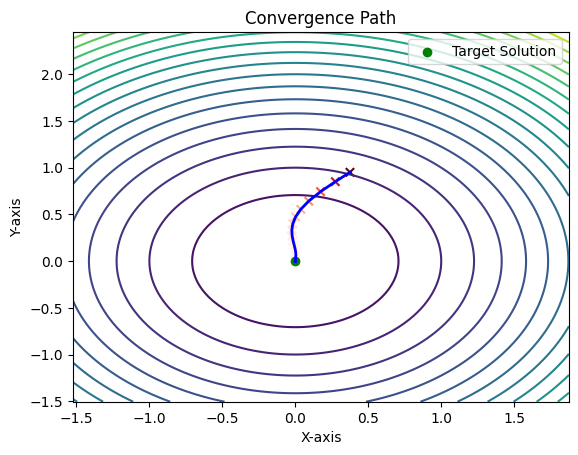

In [35]:
# Extract solutions sequence for the "BGE adam" (local implementation) optimizer
solutions_sequence = solutions["BGE_Adam"]

# Define the target solution for comparison
target_solution = torch.tensor([0, 0], dtype=torch.float32)

# Plot the convergence path
plot_convergence_path(solutions_sequence, quadratic_good, target_solution)

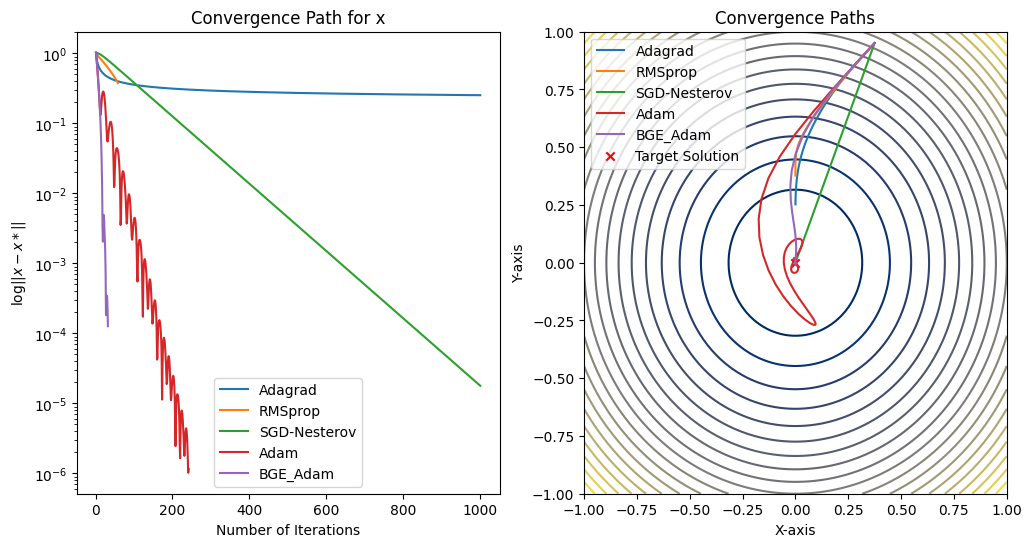

In [36]:
# Define the target solution for comparison
solutions_dict = solutions
target_solution = torch.tensor([0, 0], dtype=torch.float32)

# Plot convergence paths for different algorithms within a box
box_scale = 1
plot_multiple_convergence_paths(
    solutions_dict, quadratic_good, target_solution, box_scale=box_scale
)

## Testing and validation

#### Functions and Optimisers Preparation

| Function                                    | Objective Function | Gradient Function | Global Minimizer | Minimum Value |
|---------------------------------------------|--------------------|-------------------|---------------|---------------|
| Quadratic (poor conditioning, $\kappa=50$)   | quadratic_bad      | quadratic_bad_grad | [0,0]         | 0.0           |
| Quadratic (good conditioning, $\kappa=1$)   | quadratic_good     | quadratic_good_grad| [0,0]         | 0.0           |
| Non-convex Gaussian kernel     | gauss              | gauss_grad        | [0,0]         | 0.0           |
| Rosenbrock                                  | rosenbrock         | rosenbrock_grad   | [1,1]         | 0.0           |
| Ackley function                             | ackley             | ackley_grad       | [0,0]         | 0.0           |


In [37]:
# Dict[str, Tuple[Callable, Callable, ArrayLike[Shape=2], float]]
# {"Function name": (f, f_gradient, x_star, f_star)}

functions = {
    "Quadratic (poor conditioning, $\kappa=50$)": (
        quadratic_bad, quadratic_bad_grad, [0, 0], 0.0),
    "Quadratic (good conditioning, $\kappa=1$)": (
        quadratic_good, quadratic_good_grad, [0, 0], 0.0),
    "Non-convex Gaussian kernel": (
        gauss, gauss_grad, [0, 0], 0.0),
    "Rosenbrock": (
        rosenbrock, rosenbrock_grad, [1, 1], 0.0),
    "Ackley function": (
        ackley, ackley_grad, [0, 0], 0.0)
}
solutions.keys()

param_grid = {"lr": [0.1, 0.01, 0.001], "betas": [(0.9, 0.999), (0.91, 0.999)]}
optimal = tune_parameters(
    param_grid=param_grid,
    optimizer_cls=optim.Adam,
    x_init=[1.6, 1.1],
    loss_fn=quadratic_good,
    loss_grad=quadratic_good_grad,
    max_iter=1000,
    tol_grad= 1e-6
)
print(optimal)

{'optimal_grid': {'lr': 0.1, 'betas': (0.9, 0.999)}, 'best_n_iter': 214}


In [38]:
# Define a dictionary of optimizers with their corresponding classes
optimizers = {
    "Adam": optim.Adam,
    "SGD-Nesterov": optim.SGD,
    "RMSprop": optim.RMSprop,
    "Adagrad": optim.Adagrad,
    "BGE_Adam": BGE_Adam

}

# Define lists of beta values for Adam optimizer
betas1 = [0.3, 0.5, 0.7, 0.8, 0.9, 0.95]
betas2 = [0.999, 0.99999]
betas = list(product(betas1, betas2))

# Define parameter grids for each optimizer
param_grids = {
    "Adam": {
        "lr": 10.0**np.arange(-4, 0),
        "beta1": betas1,
        "beta2": betas2
    },
    "SGD-Nesterov": {
        "lr": 10.0**np.arange(-4, 0),
        "nesterov": [True],
        "momentum": betas1,
        "dampening": [0.0]
    },
    "RMSprop": {
        "lr": 10.0**np.arange(-4, 0),
        "momentum": betas1,
        "alpha": [0.99]
    },
    "Adagrad": {
        "lr": 10.0**np.arange(-4, 0)
    },
    "BGE_Adam": {
        "lr": 10.0**np.arange(-4, 0),
    }
}

### Quadratic Function (good conditioning)

In [39]:
# Define the target solution for optimization
x_star = torch.tensor([0, 0])

# OPTIMIZING HYPERPARAMETERS
# Uncomment the following lines to perform hyperparameter optimization
# sol_quad1, val_quad1 = optimize_workflow(
#     optimizers, param_grids, x_init,
#     loss_fn=quadratic_good, loss_grad=quadratic_good_grad
# )

In [40]:
import matplotlib.pyplot as plt
import os

# Check if latex is installed
if not os.path.exists('/usr/bin/latex'):
    print("Warning: LaTeX not found. Mathematical expressions might not render correctly.")
    plt.rcParams['text.usetex'] = False  # Disable LaTeX rendering
else:
    plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering

# ... rest of your plotting code ...

| Optimizer       | Optimizer Class  | Hyperparameters                                   |
|-----------------|------------------|---------------------------------------------------|
| Adam            | AdamOptimizer    | {"lr": 1e-1, "beta1": 0.55, "beta2": 0.999}      |
| SGD-Nesterov    | optim.SGD         | {"lr": 1e-1, "nesterov": True, "momentum": 0.5, "dampening": 0} |
| RMSprop         | optim.RMSprop     | {"lr": 1e-1, "alpha": 0.9}                        |
| Adagrad         | optim.Adagrad     | {"lr": 1e-0, "lr_decay": 0.0}                     |
| BGE_Adam        | BGE_Adam          | {"lr": 0.01}             |

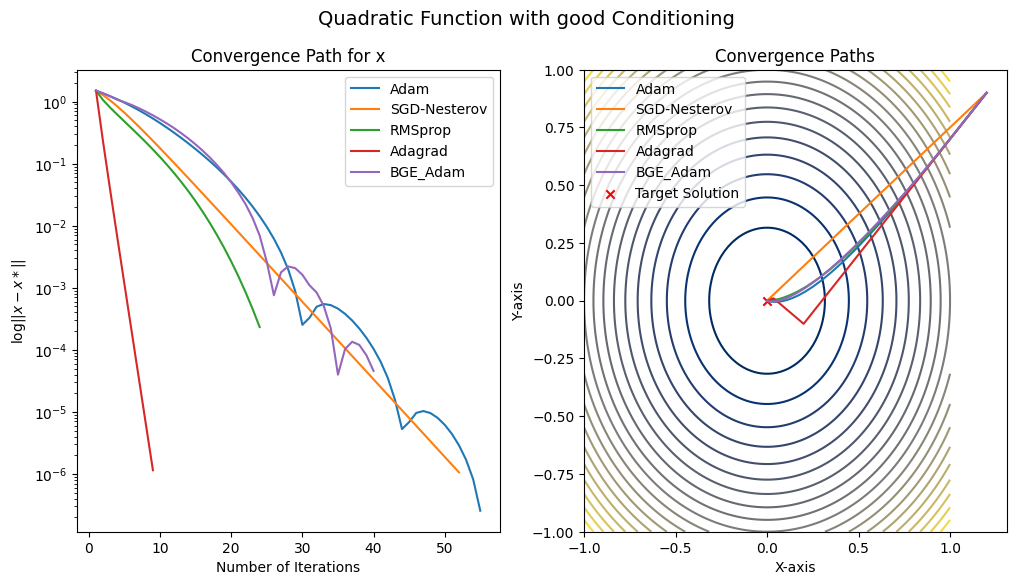

In [50]:
# Define the target solution for optimization
x_star = torch.tensor([0, 0])

# Define the optimizers and their configurations
optimizers_config = {
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.55, "beta2": 0.999}),
    "SGD-Nesterov": (optim.SGD, {
        "lr": 1e-1, "nesterov": True, "momentum": 0.5, "dampening": 0
    }),
    "RMSprop": (optim.RMSprop, {"lr": 1e-1, "alpha": 0.9}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-0, "lr_decay": 0.}),
    "BGE_Adam": (BGE_Adam, {"lr": 0.1})
}

# Run optimization with multiple optimizers
sol_quad1, values = optimize_with_multiple_optimizers(
    x_init=[1.2, 0.9],
    loss_fn=quadratic_good,
    loss_grad=quadratic_good_grad,
    optimizers_config=optimizers_config,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title = "Quadratic Function with good Conditioning" # "Quadratic Function with Good Conditioning"
plot_multiple_convergence_paths(
    sol_quad1, quadratic_good, x_star, box_scale=1, title=title
)


### Quadratic Function (bad conditioning)

In [16]:
# # Run optimization with different hyperparameter configurations for quadratic_bad function
# sol_quad2, val_quad2 = optimize_workflow(
#     optimizers, param_grids, x_init,
#     loss_fn=quadratic_bad, loss_grad=quadratic_bad_grad
# )


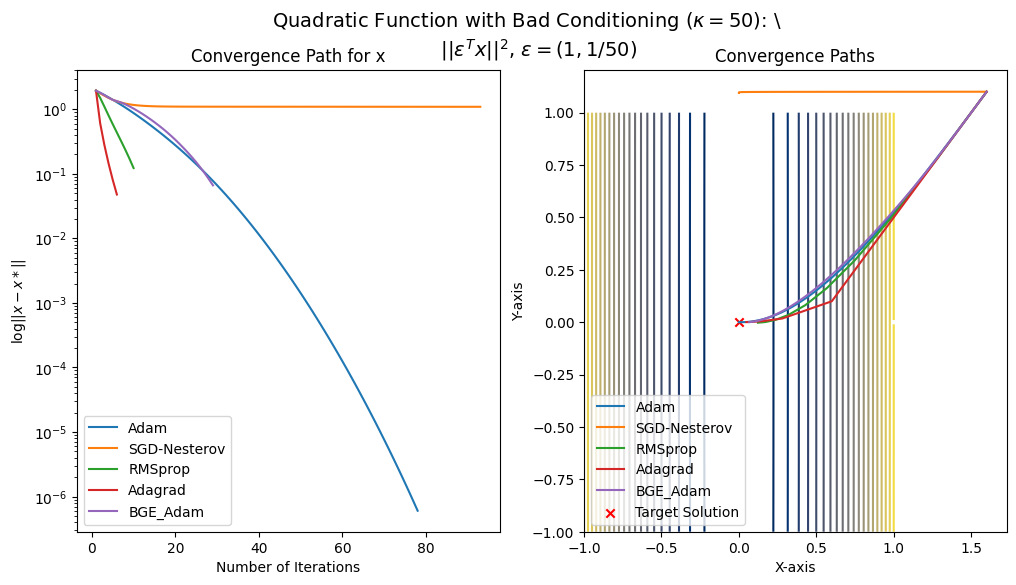

In [53]:
# Define the optimizers and their configurations for quadratic_bad function
optimizers_config = {
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.4, "beta2": 0.99999}),
    "SGD-Nesterov": (optim.SGD, {"lr": 1e-1, "nesterov": True, "momentum": 0.3, "dampening": 0}),
    "RMSprop": (optim.RMSprop, {"lr": 1e-1, "momentum": 0.3, "alpha": 0.9}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-0, "lr_decay": 0.1}),
    "BGE_Adam": (BGE_Adam, {"lr": 0.1})
}

# Run optimization with multiple optimizers for quadratic_bad function
sol_quad2, values = optimize_with_multiple_optimizers(
    x_init=[1.6, 1.1],
    loss_fn=quadratic_bad,
    loss_grad=quadratic_bad_grad,
    optimizers_config=optimizers_config,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title = rf"Quadratic Function with Bad Conditioning ($\kappa = 50$): \
    $|| \epsilon^T x ||^2$, $\epsilon = (1, 1/50)$"
plot_multiple_convergence_paths(sol_quad2, quadratic_bad, x_star, box_scale=1, title=title)

### Non-Convex Gaussian Kernel

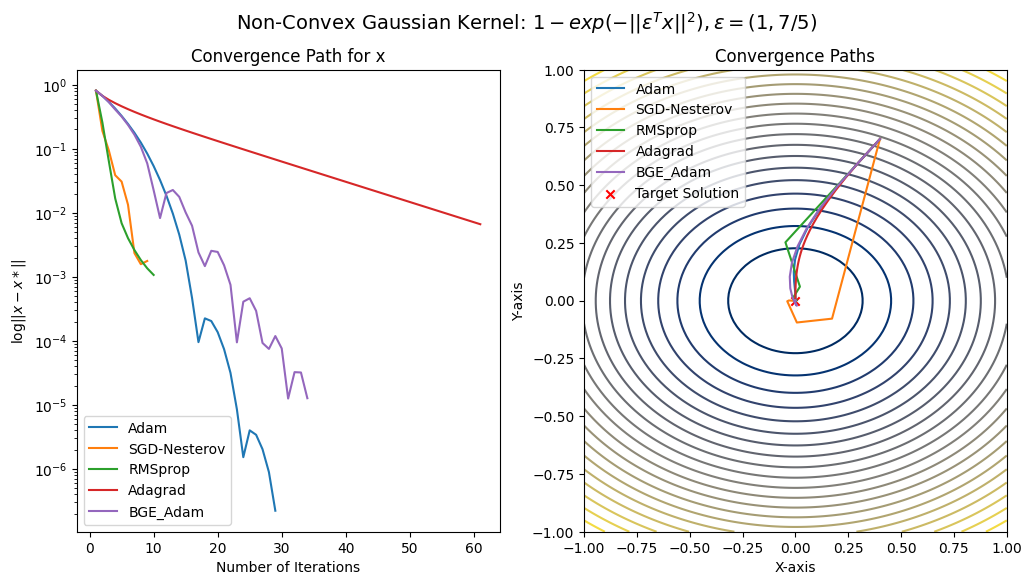

In [55]:
# Define the optimizers and their configurations for gauss function
optimizers_config_gauss = {
    "Adam": (AdamOptimizer, {
        "lr": 1e-1, "beta1": 0.3, "beta2": 0.999999
    }),
    "SGD-Nesterov": (optim.SGD, {
        "lr": 1e-0, "nesterov": True, "momentum": 0.5, "dampening": 0
    }),
    "RMSprop": (optim.RMSprop, {"lr": 1e-1, "alpha": 0.95}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-1, "lr_decay": 0.}),
    "BGE_Adam": (BGE_Adam, {"lr": 0.1})
}

# Run optimization with multiple optimizers for gauss function
sol_gauss, _ = optimize_with_multiple_optimizers(
    x_init=[0.4, 0.7],
    loss_fn=gauss,
    loss_grad=gauss_grad,
    optimizers_config=optimizers_config_gauss,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title_gauss = (
    "Non-Convex Gaussian Kernel: $1 - exp(-|| \epsilon^T x ||^2), \epsilon = (1, 7/5)$"
)
plot_multiple_convergence_paths(sol_gauss, gauss, x_star, box_scale=1, title=title_gauss)


### Rosenbrock Function (flat region)

In [57]:
# sol_rosen, val_rosen = optimize_worklow(
#     optimizers, param_grids, x_init=[1.6, 1.1],
#     loss_fn=rosenbrock, loss_grad=rosenbrock_grad
# )

x_init = [1.6, 1.1] ("above" the global solution to increase convergence likelihood)
| Optimizer       | Optimizer Class  | Hyperparameters                                   |
|-----------------|------------------|---------------------------------------------------|
| Adam            | AdamOptimizer    | {"lr": 1e-1, "beta1": 0.95, "beta2": 0.994}      |
| SGD-Nesterov    | optim.SGD         | {"lr": 1e-4, "nesterov": True, "momentum": 0.9, "dampening": 0} |
| RMSprop         | optim.RMSprop     | {"lr": 2e-3, "momentum": 0.9, "alpha": 0.99}      |
| Adagrad         | optim.Adagrad     | {"lr": 1e-2, "lr_decay": 0.0001}                  |

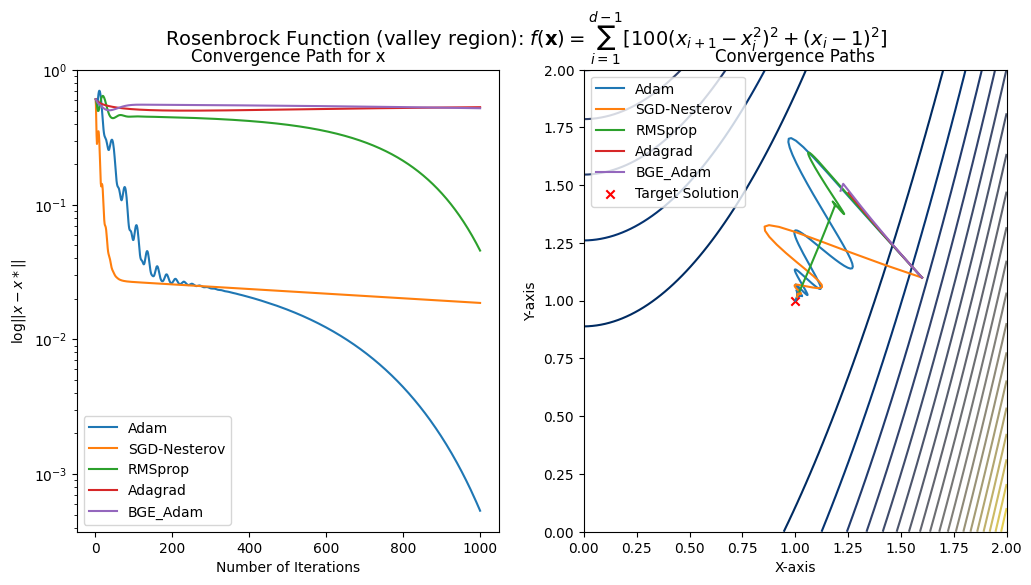

In [59]:
# Define the optimizers and their configurations for rosenbrock function
optimizers_config_rosen = {
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.95, "beta2": 0.994}),
    "SGD-Nesterov": (optim.SGD, {
        "lr": 1e-4, "nesterov": True, "momentum": 0.9, "dampening": 0
    }),
    "RMSprop": (optim.RMSprop, {"lr": 2e-3, "momentum": 0.9, "alpha": 0.99}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-2, "lr_decay": 0.0001}),
    "BGE_Adam": (BGE_Adam, {"lr": 0.01})
}

# Run optimization with multiple optimizers for rosenbrock function
sol_rosen, _ = optimize_with_multiple_optimizers(
    x_init=[1.6, 1.1],
    loss_fn=rosenbrock,
    loss_grad=rosenbrock_grad,
    optimizers_config=optimizers_config_rosen,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title_rosen = "Rosenbrock Function (valley region): $f(\mathbf{x}) = \\sum_{i=1}^{d-1} [100(x_{i+1} - x_i^2)^2 + (x_i - 1)^2]$"
plot_multiple_convergence_paths(sol_rosen, rosenbrock, x_star=torch.tensor([1, 1]), box_scale=1, title=title_rosen)


### Ackley (local minima)

In [60]:
# sol_ackley, val_ackley = optimize_worklow(
#     optimizers, param_grids, x_init,
#     loss_fn=ackley, loss_grad=ackley_grad
# )

x_init = [0.37, 0.95] (random guess)
| Optimizer       | Optimizer Class  | Hyperparameters                                   |
|-----------------|------------------|---------------------------------------------------|
| Adam            | AdamOptimizer    | {"lr": 1e-1, "beta1": 0.5, "beta2": 0.999}       |
| SGD-Nesterov    | optim.SGD         | {"lr": 1e-2, "nesterov": True, "momentum": 0.9, "dampening": 0} |
| RMSprop         | optim.RMSprop     | {"lr": 1e-2, "momentum": 0.3, "alpha": 0.9}      |
| Adagrad         | optim.Adagrad     | {"lr": 1e-0, "lr_decay": 1.17}                   |


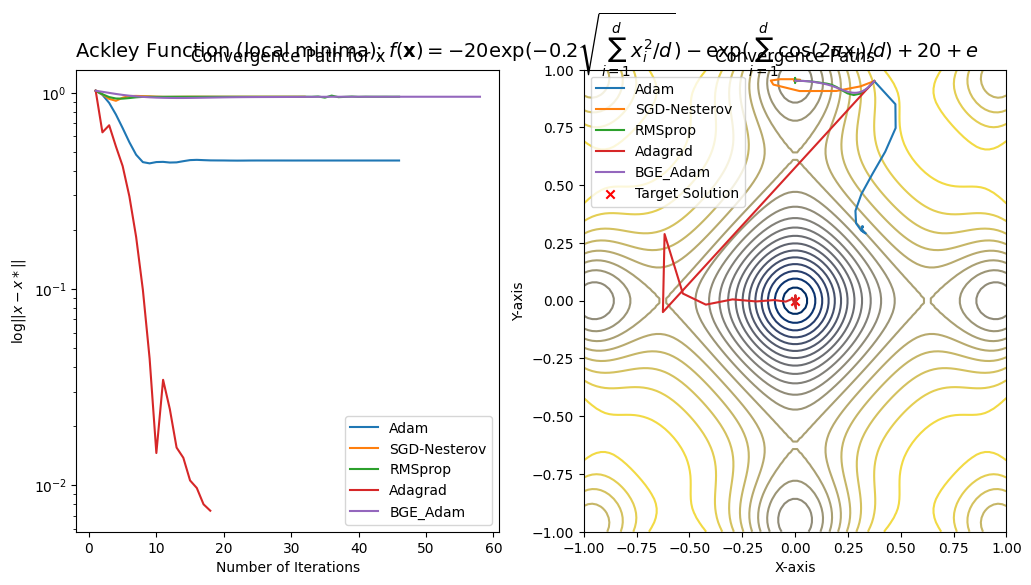

In [61]:
# Define the optimizers and their configurations for ackley function
optimizers_config_ackley = {
    "Adam": (AdamOptimizer, {"lr": 1e-1, "beta1": 0.5, "beta2": 0.999}),
    "SGD-Nesterov": (optim.SGD, {"lr": 1e-2, "nesterov": True, "momentum": 0.9, "dampening": 0}),
    "RMSprop": (optim.RMSprop, {"lr": 1e-2, "momentum": 0.3, "alpha": 0.9}),
    "Adagrad": (optim.Adagrad, {"lr": 1e-0, "lr_decay": 1.17}),
    "BGE_Adam": (BGE_Adam, {"lr": 0.01})
}

# Run optimization with multiple optimizers for ackley function
sol_ackley, _ = optimize_with_multiple_optimizers(
    x_init=x_init,
    loss_fn=ackley,
    loss_grad=ackley_grad,
    optimizers_config=optimizers_config_ackley,
    max_iter=1000,
    tol_grad=1e-6
)

# Plot convergence paths for different algorithms within a box
# Adjust title as needed
title_ackley = "Ackley Function (local minima): $f(\mathbf{x}) = -20 \exp(-0.2 \sqrt{\\sum_{i=1}^{d} x_i^2/d}) - \exp(\\sum_{i=1}^{d} \cos(2\pi x_i)/d) + 20 + e$"
plot_multiple_convergence_paths(sol_ackley, ackley, x_star=torch.tensor([0, 0]), box_scale=1, title=title_ackley)
